## Invariant Subspace Decomposition

In [72]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from nldg.old.time.utils import generate_nonlinear_data
from nldg.old.time.isd import IsdRF, IsdRF2

from scipy.linalg import block_diag
from scipy.stats import ortho_group

import matplotlib.pyplot as plt

In [91]:
n_train = 1000
n_test = 250
# p = 10
p = 10
m_train = 10
m_test = 1
# block_sizes = [2, 2, 2]
block_sizes = [2, 4, 3, 1]
# c_coeffs = [0, 1, 2]
c_coeffs = list(range(2, 9))
rng = np.random.default_rng(2001)
OM = ortho_group.rvs(dim=p, random_state=rng)
rng = np.random.default_rng(42)

Xtr, Ytr, Sigma_list_tr = generate_nonlinear_data(n_train, p, m_train, block_sizes,
                                                  c_coeffs, OM, rng)
Xts, Yts, Sigma_list_ts = generate_nonlinear_data(n_test, p, m_test, block_sizes,
                                                  c_coeffs, OM, rng, test=True)

In [92]:
ws = int(n_train/8)
n_rw = 25
isd = IsdRF2(Xtr, Ytr, [ws]*n_rw)
isd.find_invariant()

In [93]:
preds_isd_rf = isd.predict_zeroshot(Xts)

In [94]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, max_features=1.0)
rf.fit(Xtr, Ytr)
preds_rf = rf.predict(Xts)

In [95]:
mean_squared_error(Yts, preds_isd_rf), r2_score(Yts, preds_isd_rf)

(7.747453297249812, -0.6313269022665668)

In [96]:
mean_squared_error(Yts, preds_rf), r2_score(Yts, preds_rf)

(9.271796426698117, -0.9522971437053833)

In [97]:
isd.th_opt

np.float64(0.44220737292871554)

In [98]:
isd.check_const(isd.blocks_shape, isd.th_const, isd.th_opt)

(array([ True, False,  True, False, False]), [0, 1, 2, 4], [3, 5, 6, 7, 8, 9])

In [87]:
from nldg.utils.jbd import jbd, ajbd
ws = int(n_train/8)
n_rw = 25
Sigma = np.zeros((n_rw, p, p))
w = [ws]*n_rw
w_st = np.linspace(0, n_train-w[-1], num=n_rw, endpoint=True, dtype=int)
for idx, win in enumerate(w):
    X_w = Xtr[w_st[idx]:w_st[idx]+win, :]
    Sigma[idx, :, :] = np.cov(X_w, rowvar=False)
U, blocks_shape, Sigma_diag, _, _ = ajbd(Sigma)
blocks_shape

In [41]:
X_inv = Xtr[:, c_coeffs]
rfinv = RandomForestRegressor(n_estimators=50, random_state=42, max_features=1.0)
rfinv.fit(X_inv, Ytr)

RandomForestRegressor(n_estimators=50, random_state=42)

In [42]:
preds_rfinv = rfinv.predict(Xts[:, c_coeffs])

In [43]:
mean_squared_error(Yts, preds_rfinv), r2_score(Yts, preds_rfinv)

(9.30749132146099, -0.5530379316593377)

In [44]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, max_features=1.0)
rf.fit(Xtr, Ytr)
preds_rf = rf.predict(Xts)
mean_squared_error(Yts, preds_rf), r2_score(Yts, preds_rf)

(11.063904149072673, -0.8461110757238763)

## TEST

6it [11:57, 119.58s/it]


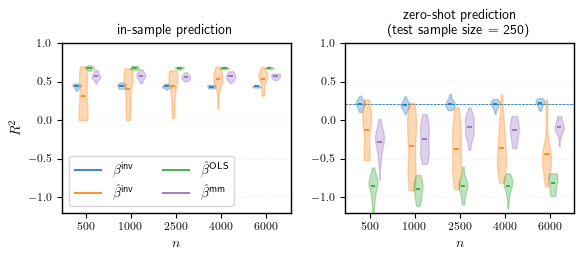

C:\Users\franc\AppData\Local\Temp\ipykernel_24532\1312891613.py:272: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(['$'+str(nn)+'$' for nn in n_hist])


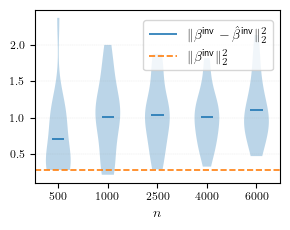

In [2]:
from __future__ import division
import numpy as np
from scipy.linalg import block_diag
from scipy.stats import ortho_group
from nldg.time.isd_dft import ISD
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}",
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'lines.linewidth': 1.2,
    'axes.unicode_minus': True,
})
width = 6.0

# functions


def gen_data(n, p, m, block_sizes, c_coeffs, OM, rng,
             test=False, test_value=0):
    # Generate observational data
    # n: sample size
    # p: covariates dimension
    # m: number of covariates shifts
    # block_sizes: sizes of diagonal blocks/partition subspaces
    # c_coeffs: indexes of constant coefficients
    # OM: orthonormal matrix used for rotation
    # rng: random generator
    # test: if True, generates test (adaptation) data
    # test_value: (list of) values of time-varying coefficients

    mu_x = np.zeros(p)

    X = np.zeros((n, p))
    Y = np.zeros((n, 1))
    eps = 0.8*rng.normal(size=(n, 1))
    gamma_0 = np.zeros((n, p))
    Sigma_list = np.zeros((n, p, p))
    ws = int(n/m)
    w_start = [j*ws for j in range(m)]

    y_mean = 0
    const = 0.2
    v_coeffs = [k not in c_coeffs for k in list(range(p))]
    shift_test = test_value
    beta_0 = np.zeros((p, 1))
    beta_0[c_coeffs] = const
    if test:
        rng_sigma = np.random.default_rng(len(shift_test))
    else:
        rng_sigma = np.random.default_rng(0)
    for idx, w in enumerate(w_start):
        if idx == m-1:
            ws = n - w_start[-1]
        A = block_diag(*[rng_sigma.random((bs, bs)) for bs in block_sizes])
        Sigma = OM.T@(A@A.T+0*np.eye(p))@OM
        for i in range(ws):
            Sigma_list[w+i, :, :] = Sigma
        X[w:w+ws, :] = rng.multivariate_normal(mean=mu_x,
                                               cov=Sigma,
                                               size=ws)
        gamma_0_w = np.zeros((p, 1))
        gamma_0_w[c_coeffs] = const
        if test:
            for j, var in enumerate(v_coeffs):
                if var:
                    gamma_0_w[j] = shift_test[idx]
            gamma_0_w = OM.T@gamma_0_w
            gamma_0[w:w+ws, :] = gamma_0_w.T
            Y[w:w+ws, :] = X[w:w+ws, :]@gamma_0_w

    if not test:
        gamma_0 = np.zeros((n, p))
        for t in range(n):
            for j in range(p):
                if j in c_coeffs:
                    gamma_0[t, j] = const
                else:
                    gamma_0[t, j] = 1-1.5*(t/n)*(np.sin((j+1)*t/n+(j+1))**2)
            gamma_0[t, :] = OM.T@gamma_0[t, :]
            Y[t, 0] = X[t, :]@gamma_0[t, :].T

    Y = Y + y_mean + eps

    return X, Y, OM.T@beta_0, gamma_0, Sigma_list


def ols(Y, X):
    # Compute OLS solution for given X and Y
    X_1 = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    return sm.OLS(Y, X_1).fit().params[:-1].reshape(-1, 1)


def main():
    rng = np.random.default_rng(42)
    n_iter = 20

    p = 10
    gt_bs = [2, 4, 3, 1]
    gt_const_coeffs = list(range(2, 9))

    tv = [-0.4, -1]
    OM = ortho_group.rvs(dim=p, random_state=rng)

    m_hist = 10     # number of covariates shift in historical data
    n_hist = [300, 500, 1000, 2500, 4000, 6000]

    m_test = len(tv)
    ws_test = 250

    n_test = 1

    n_est = 4   # number of estimators considered
    n_rw = 25   # number of windows
    n_ex = len(n_hist)

    beta = np.zeros((n_est, n_iter, n_ex, p))
    err_beta = np.zeros((n_iter, n_ex))
    err_tr = np.zeros((n_est+1, n_iter, n_ex))
    err_test = np.zeros(((n_est+1)*m_test, n_iter, n_ex))
    inv_constr_tr = np.zeros((n_est, n_iter, n_ex))
    inv_constr_test = np.zeros((n_est*m_test, n_iter, n_ex))
    S_test = []
    g_test = []

    for ni, n in tqdm(enumerate(n_hist)):
        rng_w = np.random.default_rng(0)
        n_test = ws_test*m_test

        for iter in range(n_iter):
            X_hist, Y_hist, beta_0, gamma_0, _ = \
                gen_data(n, p, m_hist, gt_bs,
                         gt_const_coeffs, OM,
                         test=False, rng=rng_w)
            ws = int(n/8)
            est = ISD(X_hist, Y_hist, [ws]*n_rw)
            beta_inv, beta_icpt, U, blocks, c_blocks = \
                est.invariant_estimator(k_fold=10)
            beta_ols = est.get_pooled_est()[:, :]
            beta_mm = est.magging_estimator()

            beta[0, iter, ni, :] = beta_0.squeeze()
            beta[1, iter, ni, :] = beta_inv.squeeze()
            beta[2, iter, ni, :] = beta_ols.squeeze()
            beta[3, iter, ni, :] = beta_mm.squeeze()

            err_beta[iter, ni] = np.linalg.norm((beta_0-beta_inv))**2

            X_test, Y_test, _, gamma_test, Sigma_test = \
                gen_data(n_test, p, m_test, gt_bs,
                         gt_const_coeffs,
                         OM, test=True,
                         test_value=tv, rng=rng_w)
            err_tr[-1, iter, ni] = np.mean((Y_hist)**2)
            count = 0
            for est_i in range(n_est):
                b = beta[est_i, iter, ni, :].reshape(-1, 1)
                err_tr[est_i, iter, ni] = np.mean((Y_hist-X_hist@b)**2)
                inv_constr_tr[est_i, iter, ni] = np.mean(ols(Y_hist-X_hist@b,
                                                             X_hist@b))
                for test_env in range(m_test):
                    X_test_env = X_test[test_env*ws_test:
                                        test_env*ws_test+ws_test, :]
                    Y_test_env = Y_test[test_env*ws_test:
                                        test_env*ws_test+ws_test, :]
                    err_test[est_i+test_env*(n_est+1), iter, ni] = \
                        np.mean((Y_test_env - X_test_env@b)**2)
                    inv_constr_test[est_i+test_env*n_est, iter, ni] = \
                        np.mean(ols(Y_test_env-X_test_env@b, X_test_env@b))
                    if count < 2:
                        err_test[n_est+test_env*(n_est+1), iter, ni] = \
                            np.mean((Y_test_env)**2)
                        if iter == 0 and ni == 0:
                            S_test.append(Sigma_test[-count, :, :])
                            g_test.append(gamma_test[-count, :])
                        count += 1

    r2_tr = np.zeros((n_est, n_iter, n_ex))
    r2_test = np.zeros((n_est*m_test, n_iter, n_ex))

    for ei in range(n_est):
        r2_tr[ei, :, :] = np.divide(err_tr[n_est, :, :]-err_tr[ei, :, :],
                                    err_tr[n_est, :, :])
        for test_env in range(m_test):
            r2_test[ei+test_env*n_est, :, :] = \
                np.divide(err_test[n_est+test_env*(n_est+1), :, :]
                          - err_test[ei+test_env*(n_est+1), :, :],
                          err_test[n_est+test_env*(n_est+1), :, :])
    
    # Plotting
    c = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red']
    bp = [None]*n_est
    bp2 = [None]*n_est
    axs0 = [None]*n_est
    axs1 = [None]*n_est
    fig, ax = plt.subplots(1, m_test, figsize=(width, width*0.45))
    for i in range(n_est):
        if i == 0:
            axs0[0] = ax[0]
            axs1[0] = ax[1]
        else:
            axs0[i] = ax[0].twinx()
            axs1[i] = ax[1].twinx()
            axs0[i].set_yticks([])
            axs1[i].set_yticks([])
        bp[i] = axs0[i].violinplot(r2_tr[i, :, 1:],
                                   showmeans=True,
                                   showextrema=False,
                                   widths=0.2,
                                   positions=np.arange(len(n_hist[1:]))+i/7)
        for j in range(m_test-1):
            bp2[i] = axs1[i].violinplot(r2_test[i+(j+1)*n_est, :, 1:],
                                        showmeans=True,
                                        showextrema=False,
                                        widths=0.2,
                                        positions=np.arange(len(n_hist[1:]))
                                        + i/7
                                        )
            g_0 = OM.T@(np.array([-1, -1, 0.2, 0.2, 0.2,
                                  0.2, 0.2, 0.2, 0.2, -1]).reshape(-1, 1))
            beta_0 = beta[0, 0, 0, :].reshape(-1, 1)
            gVXb0 = (2*g_0.T-beta_0.T)@S_test[-1]@beta_0
            VXg = g_0.T@S_test[-1]@g_0
            ax[j+1].axhline(gVXb0[0, 0] / (VXg[0, 0] + 0.8**2),
                            linestyle='--', linewidth=0.5,
                            alpha=0.5)
    for i in range(n_est):
        for vp in bp[i]['bodies']:
            vp.set_color(c[i])
        for vp in bp2[i]['bodies']:
            vp.set_color(c[i])
        bp[i]['cmeans'].set_color(c[i])
        bp2[i]['cmeans'].set_color(c[i])
        axs0[i].set_ylim([-1.2, 1])
        axs1[i].set_ylim([-1.2, 1])
    for j in range(m_test):
        ax[j].grid(color='grey', axis='y', linestyle='--', linewidth=0.25,
                   alpha=0.25)
        n_ticks = []
        for est_idx in range(n_est):
            n_ticks += [str(n_tr) for n_tr in n_hist[1:]]
    ax[0].set_xticks(np.arange(len(n_hist[1:]))+(n_est-1)/14)
    ax[0].xaxis.set_ticklabels(['$'+str(nn)+'$' for nn in n_hist[1:]])
    ax[1].set_xticks(np.arange(len(n_hist[1:]))+(n_est-1)/14)
    ax[1].xaxis.set_ticklabels(['$'+str(nn)+'$' for nn in n_hist[1:]])
    ax[0].legend([bp[0]['cmeans'], bp[1]['cmeans'],
                  bp[2]['cmeans'], bp[3]['cmeans']],
                 [r'$\beta^{\text{inv}}$', r'$\hat{\beta}^{\text{inv}}$',
                  r'$\hat{\beta}^{\text{OLS}}$', r'$\hat{\beta}^{\text{mm}}$'],
                 loc='lower left', ncol=2)
    ax[0].set_title(r'in-sample prediction', fontsize=10)
    ax[1].set_title(r'zero-shot prediction' + '\n'
                    + r'(test sample size = 250)',
                    fontsize=10)
    ax[0].set_ylabel(r'$R^2$')
    ax[0].set_xlabel(r'$n$')
    ax[1].set_xlabel(r'$n$')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(width*0.5, width*0.5*0.8))
    vp = ax.violinplot(err_beta[:, 1:], showmeans=True, showextrema=False)
    b0p = ax.axhline(y=np.linalg.norm(beta[0, 0, 0, :])**2,
                     linestyle='--', color=c[1])
    ax.xaxis.set_ticklabels(['$'+str(nn)+'$' for nn in n_hist])
    ax.set_xlabel('$n$')
    ax.grid(color='grey', axis='y', linestyle='--', linewidth=0.25,
            alpha=0.25)
    ax.legend([vp['cmeans'], b0p],
              [r'$\|\beta^{\text{inv}}-\hat{\beta}^{\text{inv}}\|^2_2$',
              r'$\|\beta^{\text{inv}}\|^2_2$'],
              loc='upper right',
              bbox_to_anchor=(1, 0.98))
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()

## TEST 2

0it [00:00, ?it/s]

0
0.4061145184982078
0
0
0
0
0
0
0.6424067135177672
0.534491542322045
0
0
0
0
0
0
0
0
0
0


1it [28:07, 1687.12s/it]

1.0
0.580193632577636
0
0
1.0
0.3690351350481317
0.4707437646452647
0
0.35911285451835534
0.46532993913188464
0.4653140795825212
0.6209438814286572
0
0
1.0
0.6912853902498364
0
0
0
0.421935850848432


2it [1:24:50, 2545.15s/it]


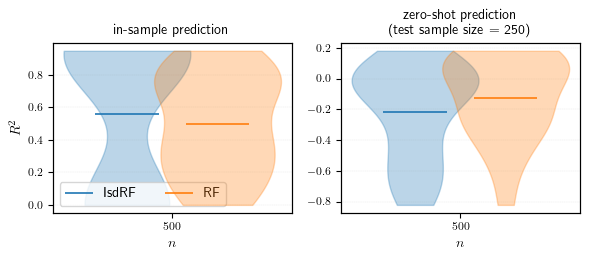

In [14]:
from __future__ import division
import numpy as np
from scipy.linalg import block_diag
from scipy.stats import ortho_group
from nldg.time.isd import IsdRF
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}",
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'lines.linewidth': 1.2,
    'axes.unicode_minus': True,
})
width = 6.0

# functions
ERR_TEST = None
R2_TEST = None

def gen_data(n, p, m, block_sizes, c_coeffs, OM, rng,
             test=False, test_value=0):
    # Generate observational data
    # n: sample size
    # p: covariates dimension
    # m: number of covariates shifts
    # block_sizes: sizes of diagonal blocks/partition subspaces
    # c_coeffs: indexes of constant coefficients
    # OM: orthonormal matrix used for rotation
    # rng: random generator
    # test: if True, generates test (adaptation) data
    # test_value: (list of) values of time-varying coefficients

    mu_x = np.zeros(p)

    X = np.zeros((n, p))
    Y = np.zeros((n,))
    eps = 0.8*rng.normal(size=(n,))
    gamma_0 = np.zeros((n, p))
    Sigma_list = np.zeros((n, p, p))
    ws = int(n/m)
    w_start = [j*ws for j in range(m)]

    y_mean = 0
    const = 0.2
    v_coeffs = [k not in c_coeffs for k in list(range(p))]
    shift_test = test_value
    beta_0 = np.zeros((p, 1))
    beta_0[c_coeffs] = const
    if test:
        rng_sigma = np.random.default_rng(len(shift_test))
    else:
        rng_sigma = np.random.default_rng(0)
    for idx, w in enumerate(w_start):
        if idx == m-1:
            ws = n - w_start[-1]
        A = block_diag(*[rng_sigma.random((bs, bs)) for bs in block_sizes])
        Sigma = OM.T@(A@A.T+0*np.eye(p))@OM
        for i in range(ws):
            Sigma_list[w+i, :, :] = Sigma
        X[w:w+ws, :] = rng.multivariate_normal(mean=mu_x,
                                               cov=Sigma,
                                               size=ws)
        gamma_0_w = np.zeros((p, 1))
        gamma_0_w[c_coeffs] = const
        if test:
            for j, var in enumerate(v_coeffs):
                if var:
                    gamma_0_w[j] = shift_test[idx]
            gamma_0_w = OM.T@gamma_0_w
            gamma_0[w:w+ws, :] = gamma_0_w.T
            Y[w:w+ws] = (X[w:w+ws, :]@gamma_0_w).ravel()

    if not test:
        gamma_0 = np.zeros((n, p))
        for t in range(n):
            for j in range(p):
                if j in c_coeffs:
                    gamma_0[t, j] = const
                else:
                    gamma_0[t, j] = 1-1.5*(t/n)*(np.sin((j+1)*t/n+(j+1))**2)
            gamma_0[t, :] = OM.T@gamma_0[t, :]
            Y[t] = X[t, :]@gamma_0[t, :].T

    Y = Y + y_mean + eps

    return X, Y, OM.T@beta_0, gamma_0, Sigma_list


def main():
    rng = np.random.default_rng(42)
    n_iter = 20

    p = 10
    gt_bs = [2, 4, 3, 1]
    gt_const_coeffs = list(range(2, 9))

    tv = [-0.4, -1]
    OM = ortho_group.rvs(dim=p, random_state=rng)

    m_hist = 10     # number of covariates shift in historical data
    n_hist = [300, 500]

    m_test = len(tv)
    ws_test = 250

    n_est = 2   # number of estimators considered
    n_rw = 25   # number of windows
    n_ex = len(n_hist)
    
    err_beta = np.zeros((n_iter, n_ex))
    err_tr = np.zeros((n_est+1, n_iter, n_ex))
    err_test = np.zeros(((n_est+1)*m_test, n_iter, n_ex))
    S_test = []
    

    for ni, n in tqdm(enumerate(n_hist)):
        rng_w = np.random.default_rng(0)
        n_test = ws_test*m_test

        for iter in range(n_iter):
            rf_list = []
            X_hist, Y_hist, _, _, _ = \
                gen_data(n, p, m_hist, gt_bs,
                         gt_const_coeffs, OM,
                         test=False, rng=rng_w)
            ws = int(n/8)
            rf_isd = IsdRF(X_hist, Y_hist, [ws]*n_rw)
            rf_isd.find_invariant(k_fold=10)
            rf_list.append(rf_isd)
            print(rf_isd.th_opt)
            
            rf = RandomForestRegressor(n_estimators=50, random_state=42, max_features=1.0)
            rf.fit(X_hist, Y_hist)
            rf_list.append(rf)

            X_test, Y_test, _, _, Sigma_test = \
                gen_data(n_test, p, m_test, gt_bs,
                         gt_const_coeffs,
                         OM, test=True,
                         test_value=tv, rng=rng_w)
            err_tr[-1, iter, ni] = np.mean((Y_hist)**2)
            count = 0
            for est_i in range(n_est):
                rf = rf_list[est_i]
                if est_i == 0:
                    preds_hist = rf.predict_zeroshot(X_hist)
                else:
                    preds_hist = rf.predict(X_hist)
                err_tr[est_i, iter, ni] = np.mean((Y_hist-preds_hist)**2)
                for test_env in range(m_test):
                    X_test_env = X_test[test_env*ws_test:
                                        test_env*ws_test+ws_test, :]
                    Y_test_env = Y_test[test_env*ws_test:
                                        test_env*ws_test+ws_test]
                    if est_i == 0:
                        preds_test_env = rf.predict_zeroshot(X_test_env)
                    else:
                        preds_test_env = rf.predict(X_test_env)
                    err_test[est_i+test_env*(n_est+1), iter, ni] = \
                        np.mean((Y_test_env - preds_test_env)**2)
                    if count < 2:
                        err_test[n_est+test_env*(n_est+1), iter, ni] = \
                            np.mean((Y_test_env)**2)
                        if iter == 0 and ni == 0:
                            S_test.append(Sigma_test[-count, :, :])
                        count += 1

    r2_tr = np.zeros((n_est, n_iter, n_ex))
    r2_test = np.zeros((n_est*m_test, n_iter, n_ex))

    for ei in range(n_est):
        r2_tr[ei, :, :] = np.divide(err_tr[n_est, :, :]-err_tr[ei, :, :],
                                    err_tr[n_est, :, :])
        for test_env in range(m_test):
            r2_test[ei+test_env*n_est, :, :] = \
                np.divide(err_test[n_est+test_env*(n_est+1), :, :]
                          - err_test[ei+test_env*(n_est+1), :, :],
                          err_test[n_est+test_env*(n_est+1), :, :])
    
    global ERR_TEST, R2_TEST
    ERR_TEST = err_test
    R2_TEST = r2_test
    
    # Plotting
    c = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red']
    bp = [None]*n_est
    bp2 = [None]*n_est
    axs0 = [None]*n_est
    axs1 = [None]*n_est
    fig, ax = plt.subplots(1, m_test, figsize=(width, width*0.45))
    for i in range(n_est):
        if i == 0:
            axs0[0] = ax[0]
            axs1[0] = ax[1]
        else:
            axs0[i] = ax[0].twinx()
            axs1[i] = ax[1].twinx()
            axs0[i].set_yticks([])
            axs1[i].set_yticks([])
        bp[i] = axs0[i].violinplot(r2_tr[i, :, 1:],
                                   showmeans=True,
                                   showextrema=False,
                                   widths=0.2,
                                   positions=np.arange(len(n_hist[1:]))+i/7)
        for j in range(m_test-1):
            bp2[i] = axs1[i].violinplot(r2_test[i+(j+1)*n_est, :, 1:],
                                        showmeans=True,
                                        showextrema=False,
                                        widths=0.2,
                                        positions=np.arange(len(n_hist[1:]))
                                        + i/7
                                        )
    for i in range(n_est):
        for vp in bp[i]['bodies']:
            vp.set_color(c[i])
        for vp in bp2[i]['bodies']:
            vp.set_color(c[i])
        bp[i]['cmeans'].set_color(c[i])
        bp2[i]['cmeans'].set_color(c[i])
        #axs0[i].set_ylim([-1.2, 1])
        #axs1[i].set_ylim([-1.2, 1])
    for j in range(m_test):
        ax[j].grid(color='grey', axis='y', linestyle='--', linewidth=0.25,
                   alpha=0.25)
        n_ticks = []
        for est_idx in range(n_est):
            n_ticks += [str(n_tr) for n_tr in n_hist[1:]]
    ax[0].set_xticks(np.arange(len(n_hist[1:]))+(n_est-1)/14)
    ax[0].xaxis.set_ticklabels(['$'+str(nn)+'$' for nn in n_hist[1:]])
    ax[1].set_xticks(np.arange(len(n_hist[1:]))+(n_est-1)/14)
    ax[1].xaxis.set_ticklabels(['$'+str(nn)+'$' for nn in n_hist[1:]])
    ax[0].legend([bp[0]['cmeans'], bp[1]['cmeans']],
                 [r'$\mathsf{IsdRF}$', r'$\mathsf{RF}$'], loc='lower left', ncol=2)
    ax[0].set_title(r'in-sample prediction', fontsize=10)
    ax[1].set_title(r'zero-shot prediction' + '\n'
                    + r'(test sample size = 250)',
                    fontsize=10)
    ax[0].set_ylabel(r'$R^2$')
    ax[0].set_xlabel(r'$n$')
    ax[1].set_xlabel(r'$n$')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()

In [16]:
R2_TEST.shape

(4, 20, 2)